# Hands-on 03: Tabular data and NNs: Classifying particle jets

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler




import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


2025-02-16 23:33:19.083982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 23:33:19.090520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739745199.099296  217658 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739745199.102168  217658 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 23:33:19.111276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

## Let’s print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(f"Feature names: {data['feature_names']}")
print(f"Target names: {y.dtype.categories.to_list()}")
print(f"Shapes: {X.shape}, {y.shape}")
print(f"Inputs: {X}")
print(f"Targets: {y}")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
Target names: ['g', 'q', 't', 'w', 'z']
Shapes: (830000, 16), (830000,)
Inputs:            zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.0400

Many of these variables are energy correlation functions $N,`M,~C,$ and $D$ (1305.0007, 1609.07483). The others are the jet mass (computed with modified mass drop) $m_\text{mMDT}$, $\sum z\log z$
,
where the sum is over the particles in the jet and
is the fraction of jet momentum carried by a given particle, and the overall multiplicity of particles in the jet.

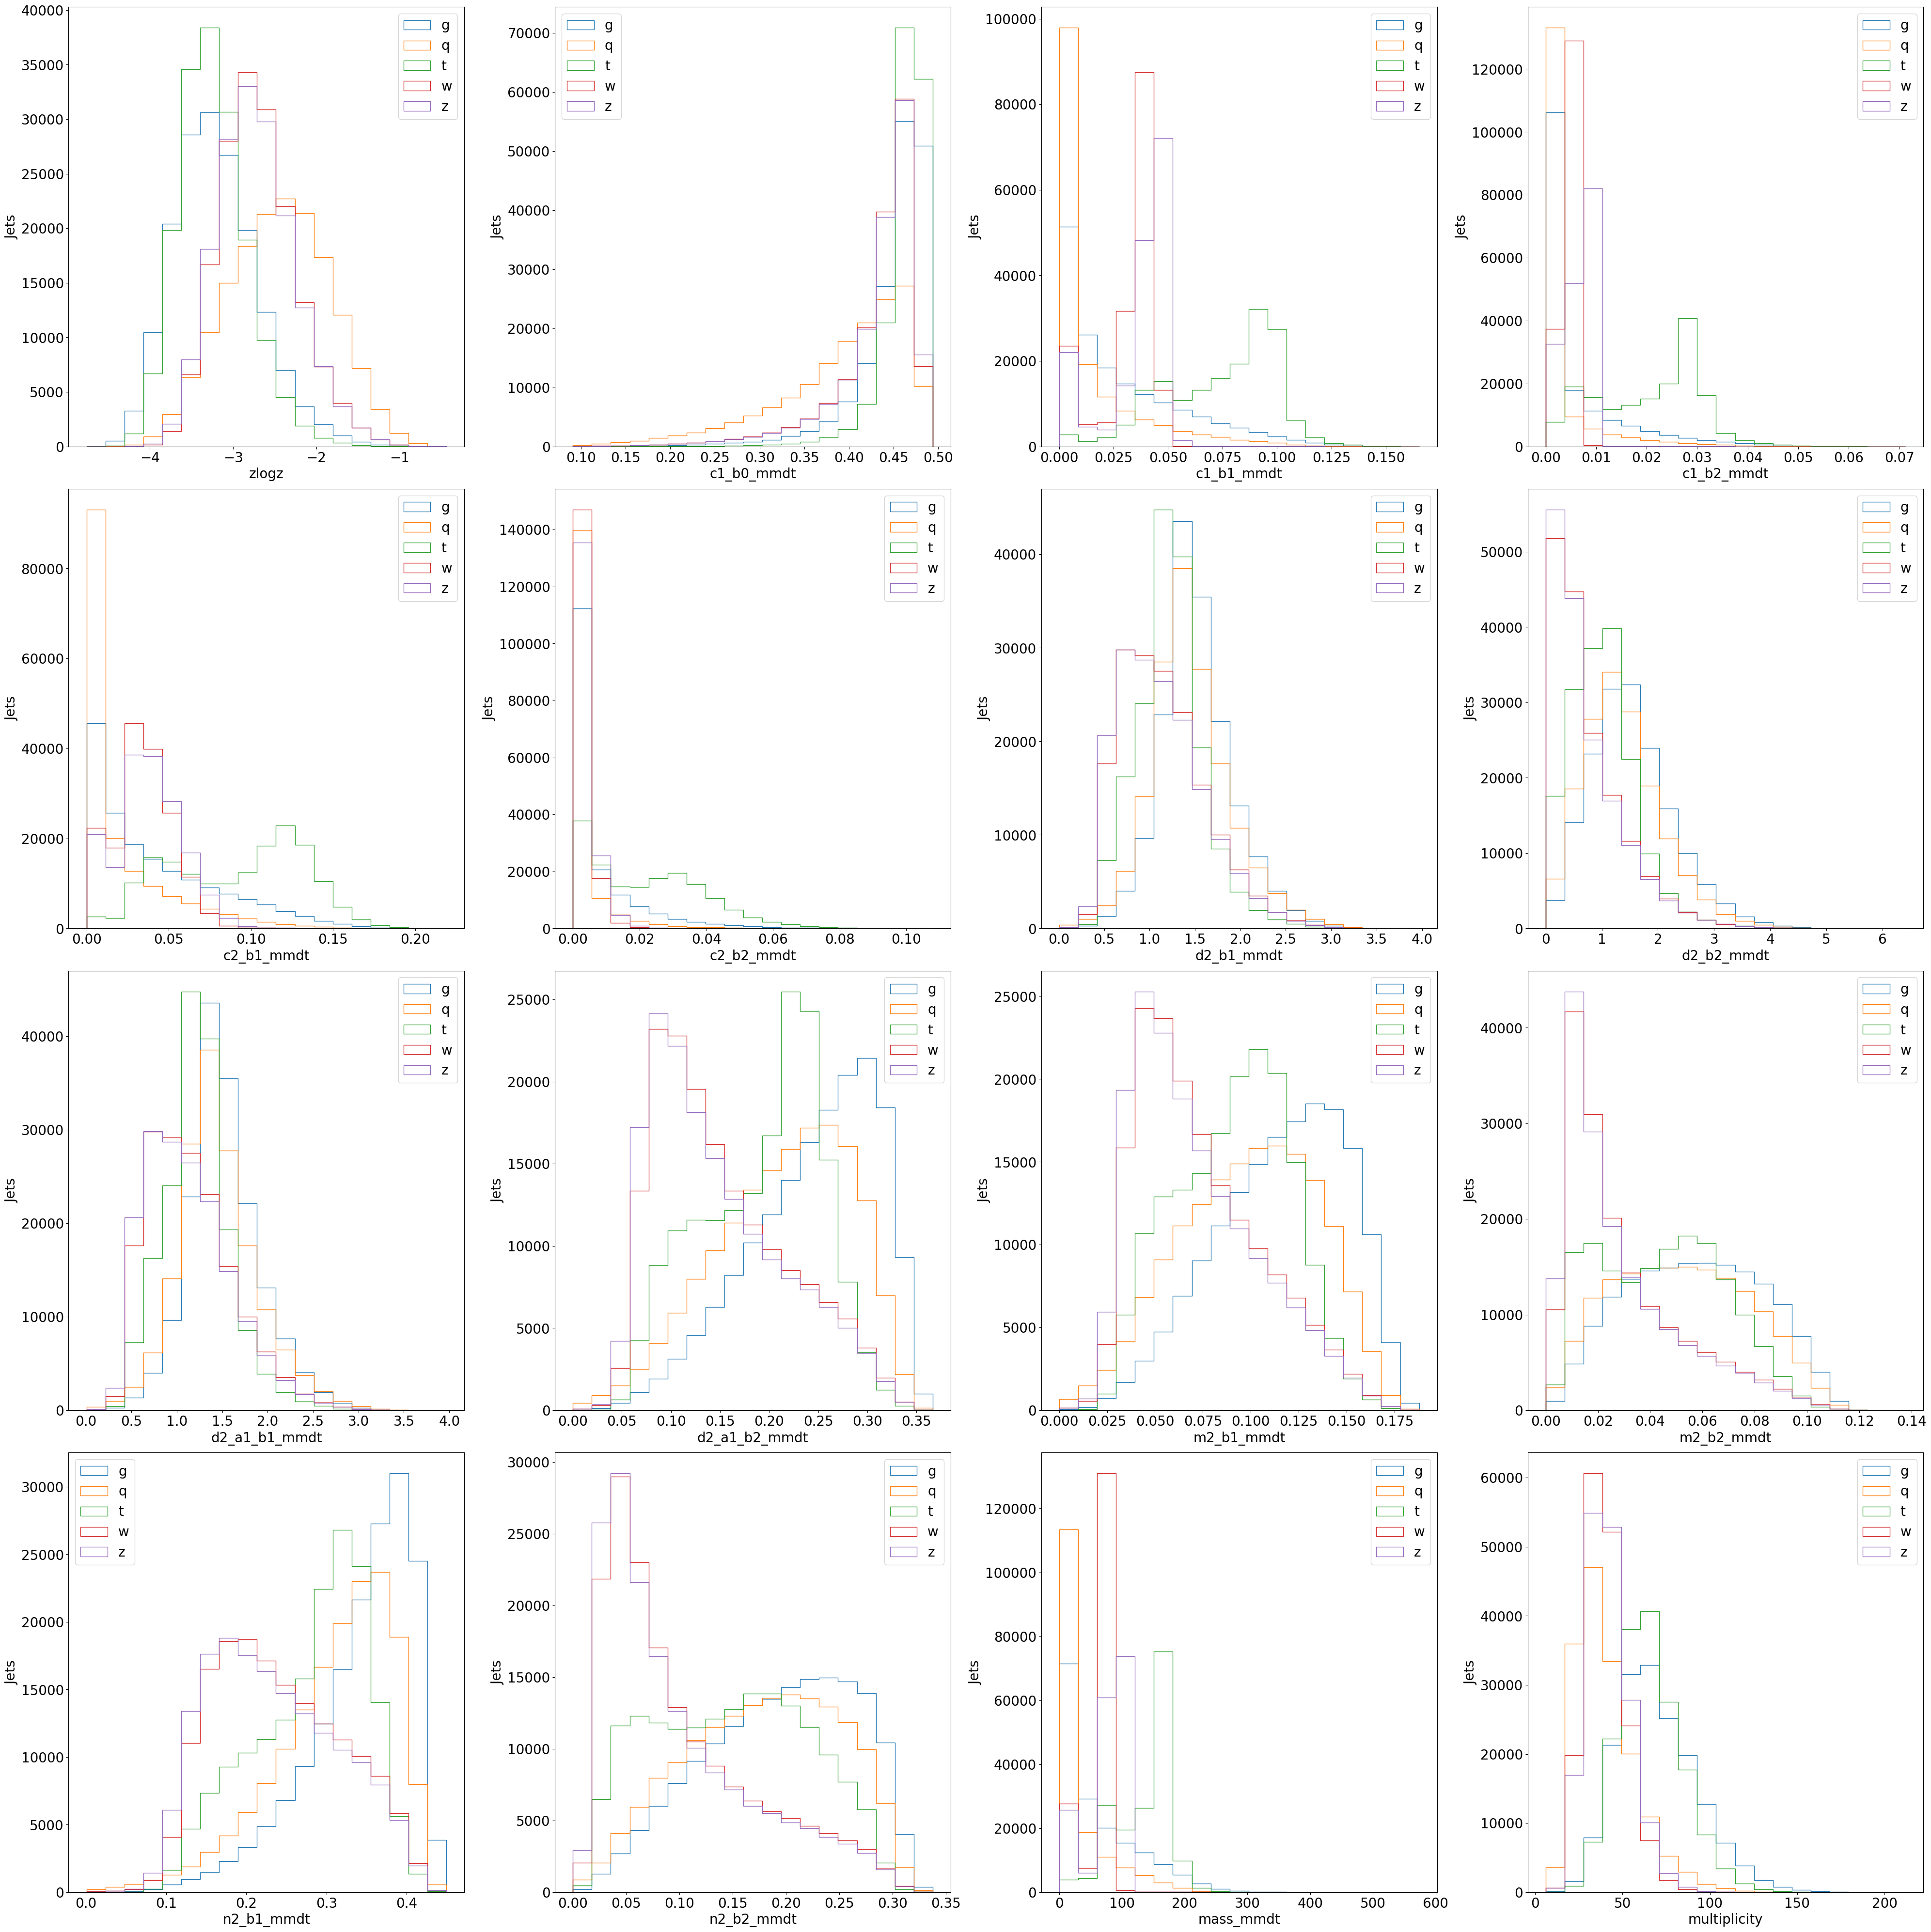

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 40))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 20)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

Because the `y` target is an array of strings, e.g. `["g", "w", ...]`, we need to make this a “one-hot” encoding for the training. Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y_onehot = le.fit_transform(y)
y_onehot = to_categorical(y_onehot, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(y[:5])
print(y_onehot[:5])

0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, object): ['g', 'q', 't', 'w', 'z']
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


## Now construct a simple neural network
We’ll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1

In [7]:
model = Sequential(name="sequantial1")
model.add(Dense(64, input_shape=(16,), name="fc1"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()

/home/ilija/anaconda3/envs/deep-learn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739745206.394918  217658 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1165 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model
We’ll use SGD optimizer with categorical crossentropy loss. The model isn’t very complex, so this should just take a few minutes even on the CPU

In [8]:
model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

I0000 00:00:1739745207.045202  217803 service.cc:148] XLA service 0x71c4140054f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739745207.045227  217803 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-02-16 23:33:27.054649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739745207.081496  217803 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-02-16 23:33:27.862723: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 136 bytes spill stores, 136 bytes spill loads

2025-02-16 23:33:28.067931: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220

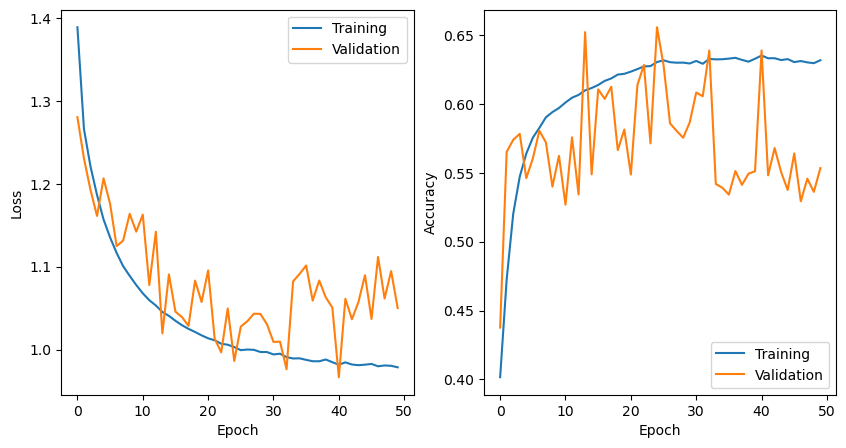

In [9]:
from plotting import plot_model_history

plot_model_history(history)

## Check performance
Check the accuracy and make a ROC curve

In [10]:
from plotting import make_roc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.5527168674698795


<Figure size 500x500 with 0 Axes>

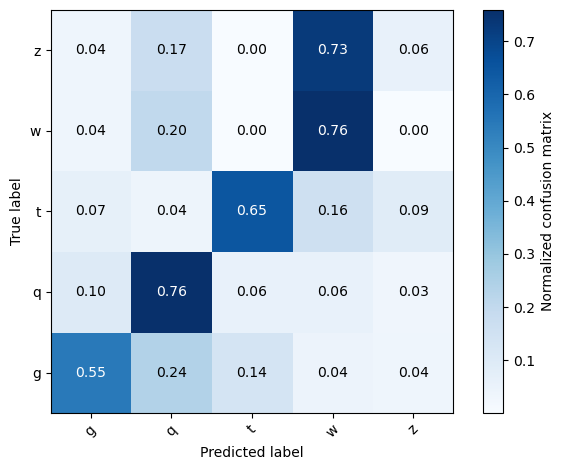

In [11]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

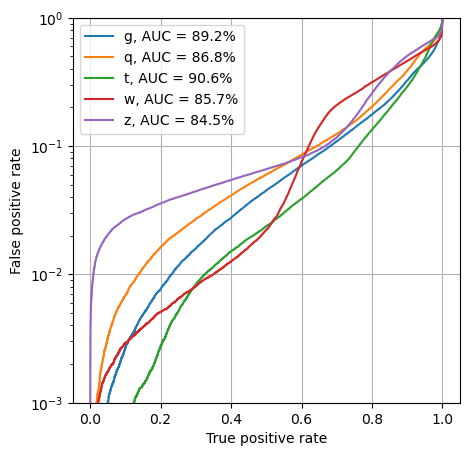

In [12]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

# Exercises
## 1.  Apply a standard scaler to the inputs. How does the performance of the model change?


In [13]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

### Training the model

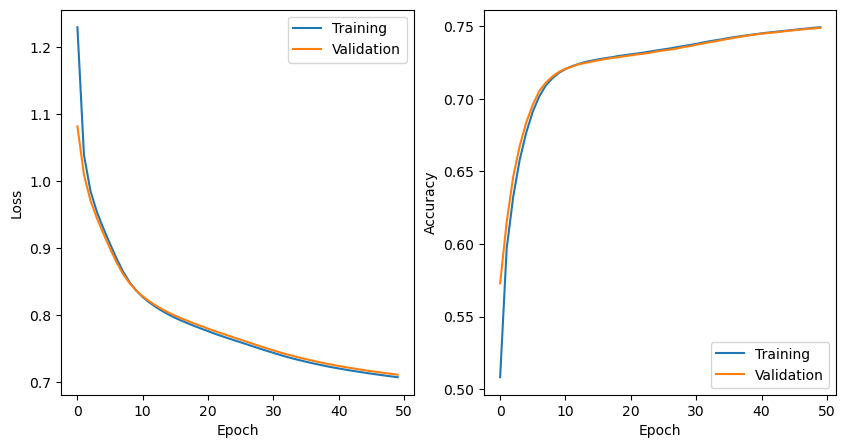

In [14]:
# Training the model
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

From the loss curves, we can already see that the performance of the model has improved considerably as the stability of the loss curves is increases. Moreover the accurary seems to increase much more stably. In addition, the accuracy of the validation closely follows that of the training data. 

### Checking performance

Accuracy: 0.7475180722891567


<Figure size 500x500 with 0 Axes>

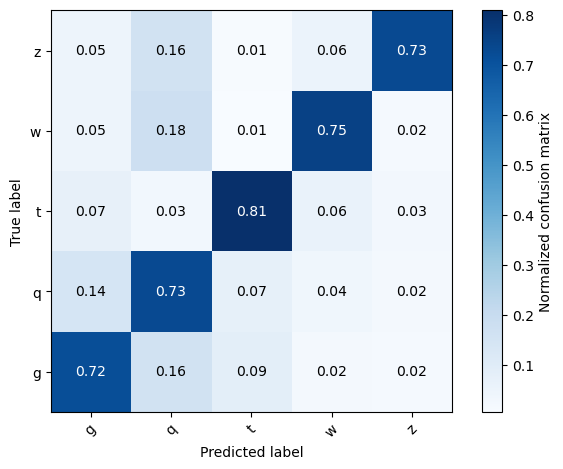

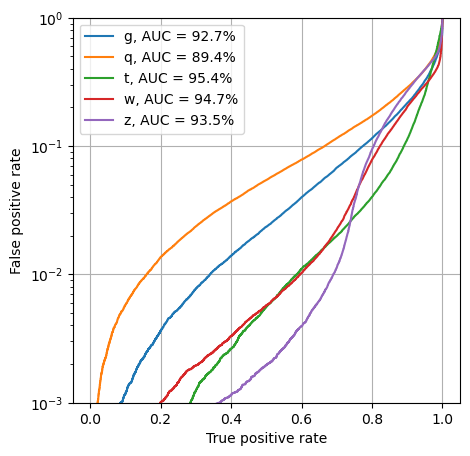

In [15]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

The performace of the network is improved as seen from the increase in the total accuracy (55.27% to 74.75%) along with the increased AUC for the ROC curves. Furthermore, from the confusion matrix, we see that the predicted labels all match with the true labels (diagonals have highest values). 

## 2. Apply L1 regularization. How does the performance of the model change? How do the distribution of the weight values change?

### Redifining model

In [16]:

model = Sequential(name="sequantial1")
model.add(Dense(64, input_shape=(16,), name="fc1", kernel_regularizer=l1(0.01)))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()


/home/ilija/anaconda3/envs/deep-learn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

QUESTION: Should we still have the standared scaler applied to the inputs?

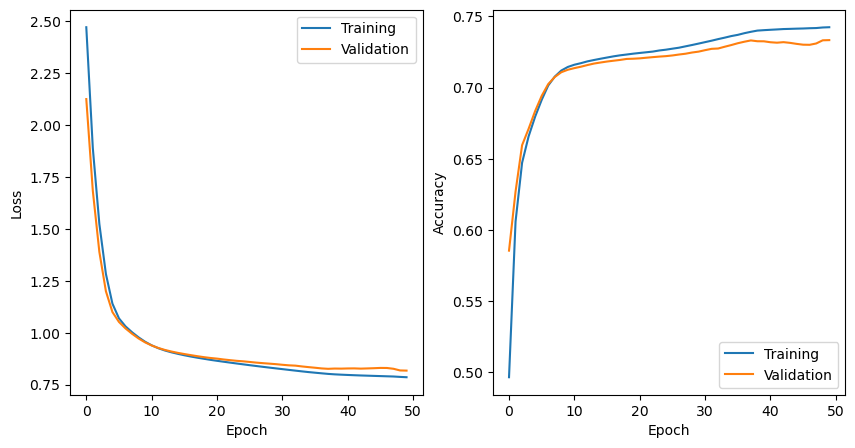

In [17]:
# Training the model


#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

### Checking performance

Accuracy: 0.7316325301204819


<Figure size 500x500 with 0 Axes>

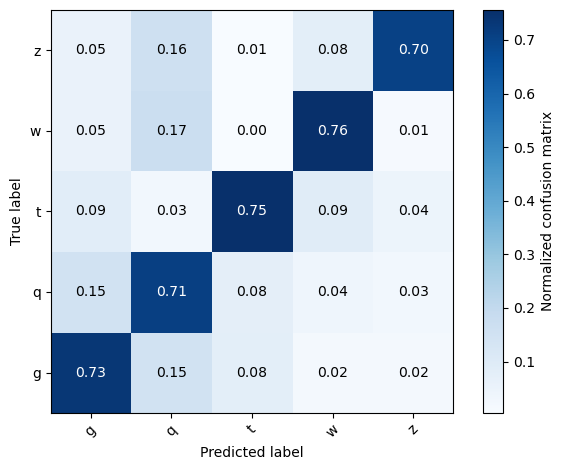

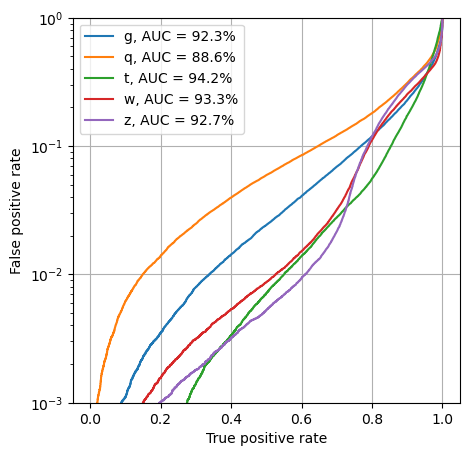

In [18]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

We see a slight decrease in the total accuracy when adding the L1 regulator. Moreover, we see that both the training and validation loss slightly increased. However, stability is still maintained for both curves. 

## 3. How do the loss curves change if we use a smaller learning rate (say `1e-5`) or a larger one (say `0.1`)?

### Smaller Learning rate

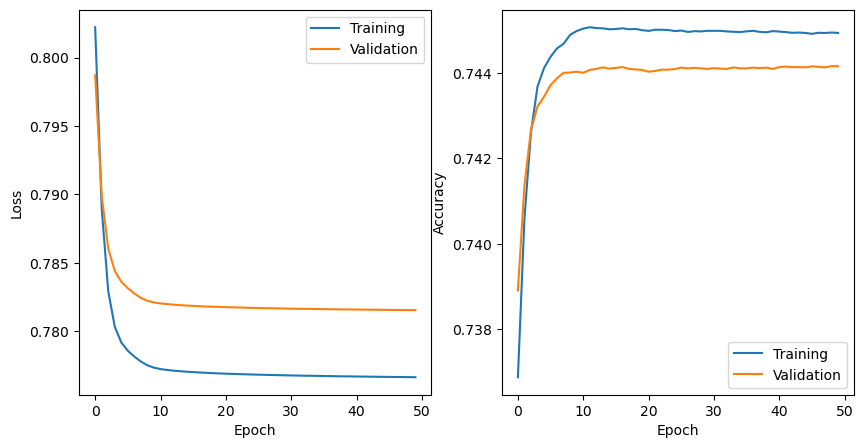

In [19]:
optimizer_smaller = SGD(learning_rate=1e-5)

model.compile(optimizer=optimizer_smaller, loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)


We see that the accruary remains approximately the same. However, the loss and accuracy of the training is noticibly better for the training data than for the validation.  

Accuracy: 0.7433132530120482


<Figure size 500x500 with 0 Axes>

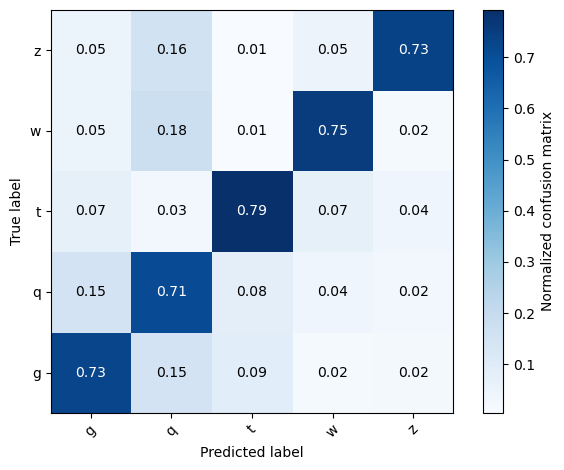

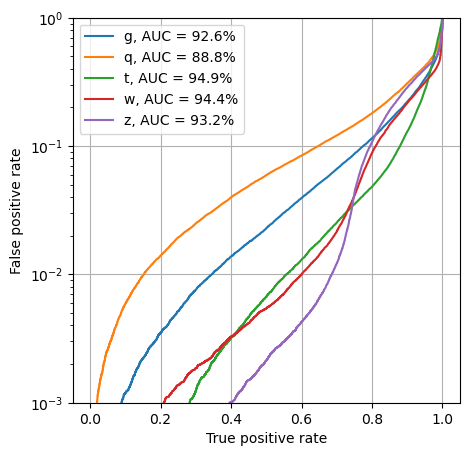

In [20]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

The accuracy is found to be 74.33% which is comparable to the value using default learning rate of 0.01. Therefore, in this case, the use of a smaller learning rate is not that useful.  

### Larger learning rate

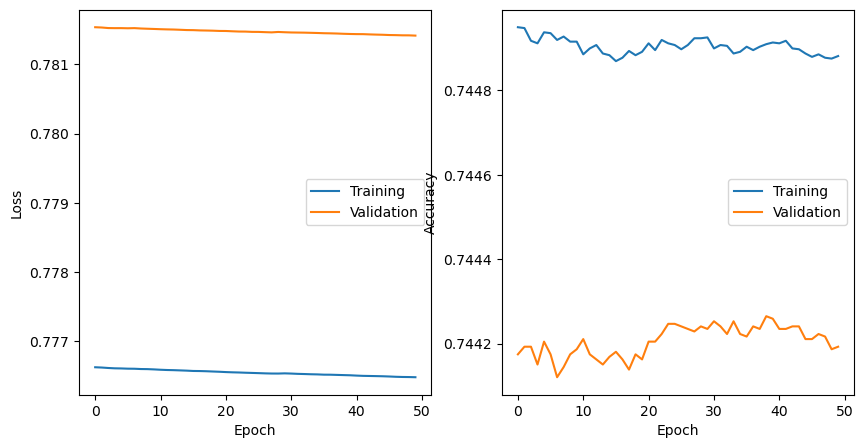

In [21]:
optimizer_larger = SGD(learning_rate=0.1)
model.compile(optimizer=optimizer_smaller, loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

We see that for a larger learning rate, neither the loss nor the accuracy converge for both the training and validation data. However, both values are comparable to the smaller and default learning rates. This might be due to the batch size being large enough to obtain a significantly accurate estimate of the true derivative. Thus, with this learning rate, fewer epochs are needed to reach a loss and accurary comparable to the smaller learning rates. It is worth noteting that, similar to the learing rate of `1e-5`. the accuracy and loss are both significantly better on the training data than the validation data. 

Accuracy: 0.7432590361445783


<Figure size 500x500 with 0 Axes>

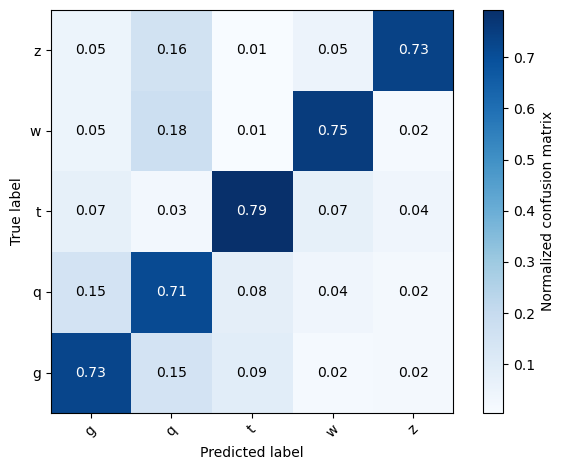

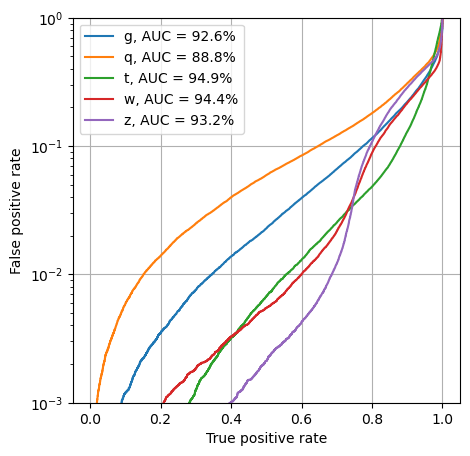

In [22]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

An accuracy of 74.33% was obtained using the larger learning rate. This is better than the smaller learning rate of `1e-5` but still very slightly less than the accuracy of 74.75% for when only scaling was applied. 

## 4. How does the loss curve change and the performance of the model change if we use Adam as the optimizer instead of SGD?

2025-02-16 23:37:36.906577: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 88 bytes spill stores, 88 bytes spill loads

2025-02-16 23:37:36.957256: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_388', 172 bytes spill stores, 172 bytes spill loads

2025-02-16 23:37:37.043917: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_390', 136 bytes spill stores, 136 bytes spill loads

2025-02-16 23:37:37.166425: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 2724 bytes spill stores, 2712 bytes spill loads

2025-02-16 23:37:37.168376: I external/local_xla/xla/str

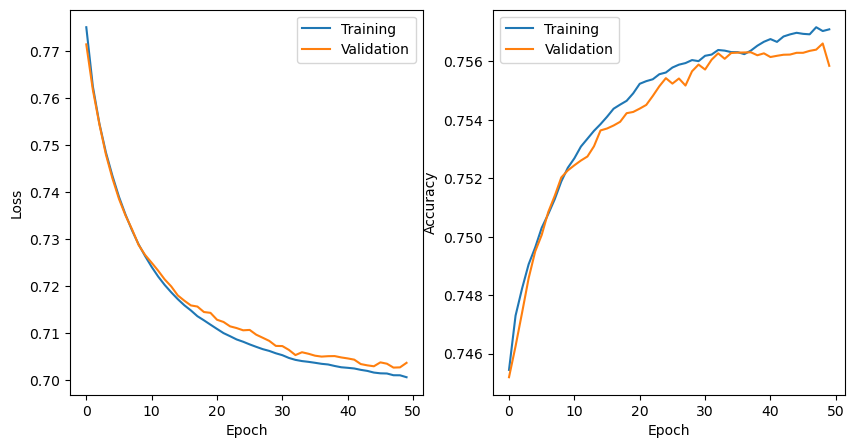

In [23]:
model.compile(optimizer='adam', loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

When using Adam, we see that the both the accuracy and the loss converge for the training and validation data. Furthermore, both are comparable between the training and validation data.

Accuracy: 0.7552710843373494


<Figure size 500x500 with 0 Axes>

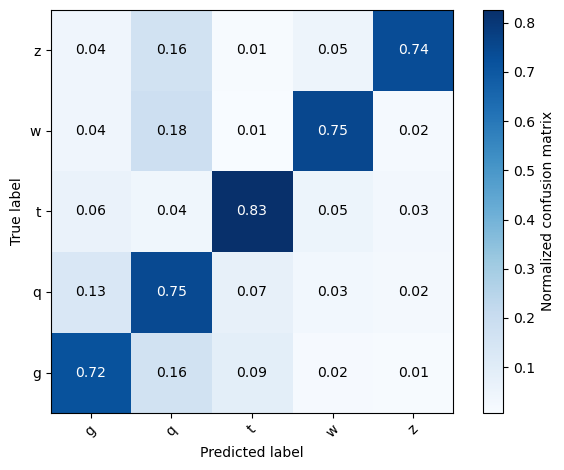

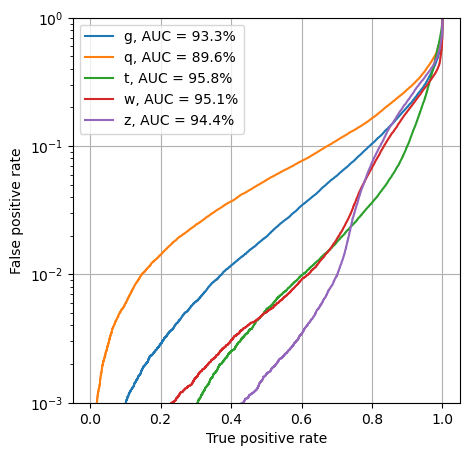

In [24]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

We see that with using adam, the highest accuracy of 75.53% was achieved. 